## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-05 03:44:49.900 | INFO     |  Running on cpu


In [3]:
task = 'BlockDrawerRed'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-08-05 03:44:56.285 | INFO     |  Loading dataset(s): 
2025-08-05 03:44:56.286 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockDrawerRed/demos/metadata.json
2025-08-05 03:44:56.290 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-05 03:44:56.290 | INFO     |    Extracted tsdf object labels []
2025-08-05 03:44:56.290 | INFO     |    Done! Data contains 4 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([180, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([180]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([180, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([180, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([180, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([180, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    velocity_threshold=0.002,
    min_end_distance=20,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 03:45:09.744 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:45:09.744 | INFO     |  Performing fitting actions: [INIT]
2025-08-05 03:45:09.744 | INFO     |  Segmenting trajectories


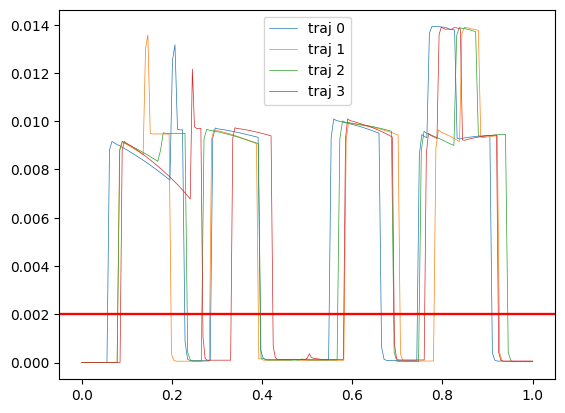

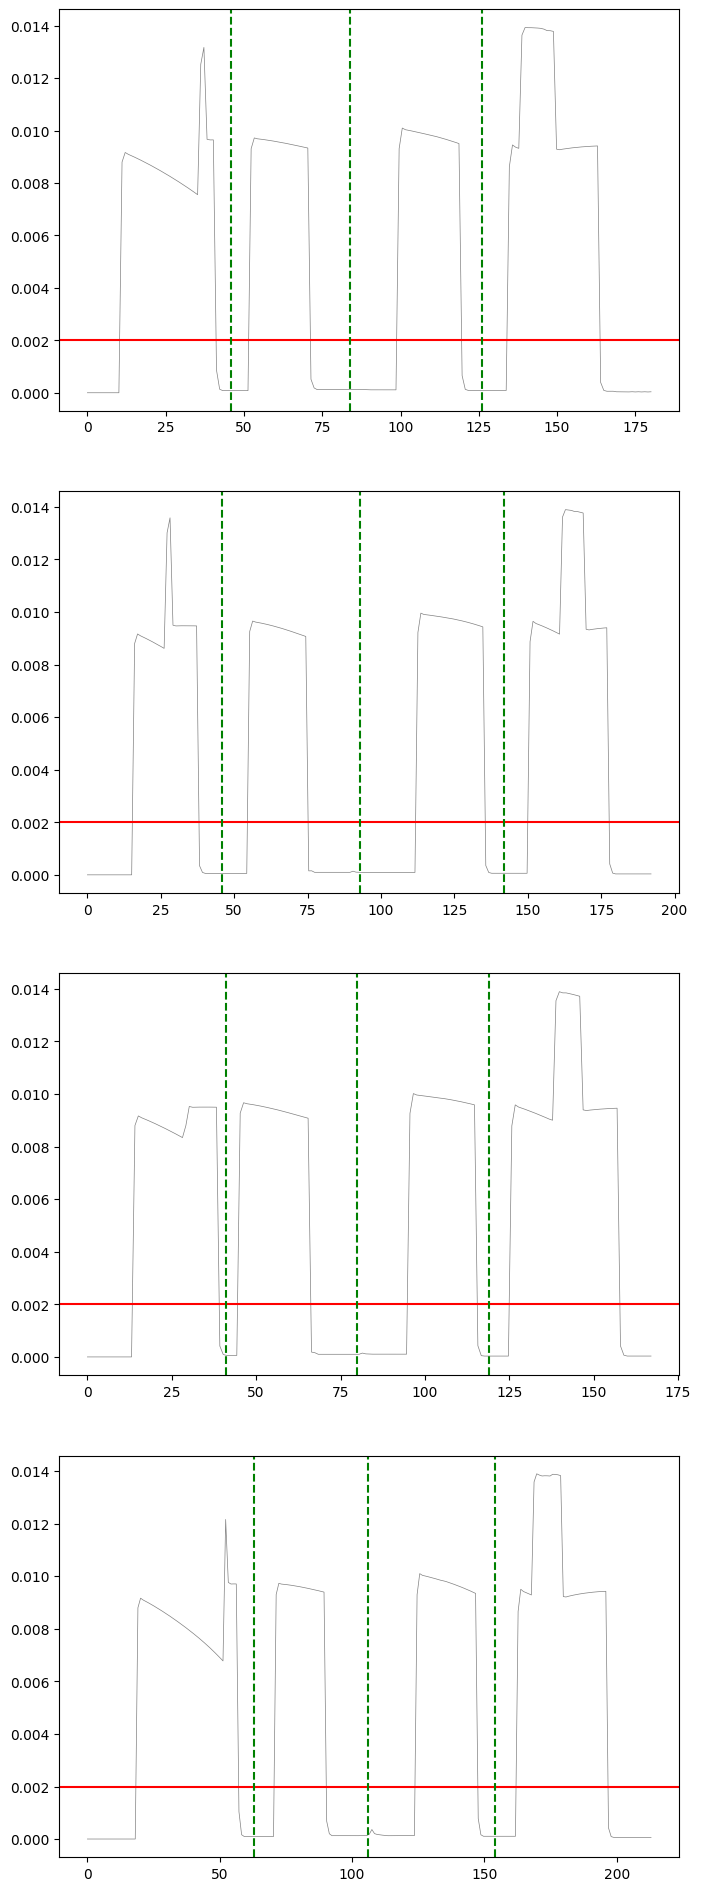

2025-08-05 03:45:11.565 | INFO     |  Creating segement of demos.
2025-08-05 03:45:11.572 | INFO     |  Subsampling to length 58 using strategy mean-length.
2025-08-05 03:45:11.574 | INFO     |  Creating segement of demos.
2025-08-05 03:45:11.586 | INFO     |  Subsampling to length 50 using strategy mean-length.
2025-08-05 03:45:11.587 | INFO     |  Creating segement of demos.
2025-08-05 03:45:11.598 | INFO     |  Subsampling to length 53 using strategy mean-length.
2025-08-05 03:45:11.600 | INFO     |  Creating segement of demos.
2025-08-05 03:45:11.608 | INFO     |  Subsampling to length 61 using strategy mean-length.
2025-08-05 03:45:11.611 | INFO     |  ... created 4 segments
2025-08-05 03:45:11.611 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:45:11.612 | INFO     |    Creating partial frame view of demos.
2025-08-05 03:45:11.619 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-08-05 03:45:11.619 | INFO     |    Changing number of components to 2
2025-08-05 03:45:

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:11.829 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:45:11.830 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:12.202 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:45:12.203 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:12.473 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:45:12.474 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:12.687 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:45:12.688 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:12.902 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:45:12.903 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:13.139 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:45:13.141 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:13.575 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:45:13.576 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:13.803 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:45:13.804 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:14.017 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:45:14.018 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:14.282 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-08-05 03:45:14.284 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-08-05 03:45:14.284 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-08-05 03:45:14.284 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-08-05 03:45:14.284 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-08-05 03:45:14.284 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-08-05 03:45:14.284 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-08-05 03:45:14.284 | INFO     |  obj006     score (rel):     -0 (0.628)
2025-08-05 03:45:14.285 | INFO     |  obj007     score (rel):     -0 (0.029)
2025-08-05 03:45:14.285 | INFO     |  obj008     score (rel):     -0 (0.034)
2025-08-05 03:45:14.286 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:45:14.333 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:45:14.334 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:14.546 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:45:14.546 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:14.750 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:45:14.751 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:14.959 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:45:14.961 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:15.141 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:45:15.142 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:15.342 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:45:15.345 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:15.622 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:45:15.625 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:15.925 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:45:15.926 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:16.103 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:45:16.104 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:16.291 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:45:16.292 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:16.481 | INFO     |  ee_init    score (rel):     -0 (0.156)
2025-08-05 03:45:16.482 | INFO     |  obj000     score (rel):     -0 (0.156)
2025-08-05 03:45:16.483 | INFO     |  obj001     score (rel):     -0 (0.156)
2025-08-05 03:45:16.483 | INFO     |  obj002     score (rel):     -0 (0.156)
2025-08-05 03:45:16.483 | INFO     |  obj003     score (rel):     -0 (0.156)
2025-08-05 03:45:16.483 | INFO     |  obj004     score (rel):     -0 (0.156)
2025-08-05 03:45:16.483 | INFO     |  obj005     score (rel):     -0 (0.156)
2025-08-05 03:45:16.483 | INFO     |  obj006     score (rel):     -0 (1.000)
2025-08-05 03:45:16.483 | INFO     |  obj007     score (rel):     -0 (0.003)
2025-08-05 03:45:16.483 | INFO     |  obj008     score (rel):     -0 (0.012)
2025-08-05 03:45:16.484 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:45:16.486 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:45:16.487 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:16.688 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:45:16.689 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:16.912 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:45:16.913 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:17.081 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:45:17.083 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:17.299 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:45:17.300 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:17.510 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:45:17.511 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:17.719 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:45:17.720 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:18.058 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:45:18.059 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:18.252 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:45:18.253 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:18.457 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:45:18.459 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:45:18.673 | INFO     |  ee_init    score (rel):     -0 (0.212)
2025-08-05 03:45:18.674 | INFO     |  obj000     score (rel):     -0 (0.212)
2025-08-05 03:45:18.674 | INFO     |  obj001     score (rel):     -0 (0.212)
2025-08-05 03:45:18.674 | INFO     |  obj002     score (rel):     -0 (0.212)
2025-08-05 03:45:18.674 | INFO     |  obj003     score (rel):     -0 (0.212)
2025-08-05 03:45:18.674 | INFO     |  obj004     score (rel):     -0 (0.212)
2025-08-05 03:45:18.674 | INFO     |  obj005     score (rel):     -0 (0.212)
2025-08-05 03:45:18.675 | INFO     |  obj007     score (rel):     -0 (0.004)
2025-08-05 03:45:18.675 | INFO     |  obj008     score (rel):     -0 (0.014)
2025-08-05 03:45:18.676 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:45:18.678 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:45:18.679 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:18.905 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:45:18.906 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:19.146 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:45:19.147 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:19.364 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:45:19.365 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:19.613 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:45:19.614 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:19.831 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:45:19.832 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:20.129 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:45:20.130 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:20.509 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:45:20.509 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:20.769 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:45:20.770 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:20.989 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:45:20.990 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:45:21.287 | INFO     |  ee_init    score (rel):     -0 (0.403)
2025-08-05 03:45:21.289 | INFO     |  obj000     score (rel):     -0 (0.403)
2025-08-05 03:45:21.289 | INFO     |  obj001     score (rel):     -0 (0.403)
2025-08-05 03:45:21.290 | INFO     |  obj002     score (rel):     -0 (0.403)
2025-08-05 03:45:21.290 | INFO     |  obj003     score (rel):     -0 (0.403)
2025-08-05 03:45:21.290 | INFO     |  obj004     score (rel):     -0 (0.403)
2025-08-05 03:45:21.290 | INFO     |  obj005     score (rel):     -0 (0.403)
2025-08-05 03:45:21.290 | INFO     |  obj007     score (rel):     -0 (0.025)
2025-08-05 03:45:21.290 | INFO     |  obj008     score (rel):     -0 (0.020)
2025-08-05 03:45:21.291 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:45:21.293 | INFO     |  Segmented trajs into 4 segments
2025-08-05 03:45:21.327 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.140920 -0.140920 -

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:45:21.405 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1
2025-08-05 03:45:21.406 | INFO     |  Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[2.22e+061, 2.22e+061, 2.15e+061, 2.04e+061, 1.87e+061, 1.67e+061,
          1.45e+061, 1.22e+061, 1.00e+061, 8.01e+060, 6.22e+060, 4.69e+060,
          3.43e+060, 1.36e+060, 1.55e+059, 5.24e+057, 5.32e+055, 1.66e+053,
          1.64e+050, 5.19e+046, 5.43e+042, 1.92e+038, 2.33e+033, 1.01e+028,
          1.61e+022, 9.62e+015, 2.22e+009, 2.02e+002, 7.51e-006, 3.41e-006,
          5.16e-014, 3.38e-022, 9.85e-031, 1.31e-039, 8.27e-049, 2.54e-058,
          3.94e-068, 3.18e-078, 1.38e-088, 4.08e-102, 4.99e-117, 1.18e-121,
          2.56e-126, 1.32e-131, 1.94e-131, 9.07e-132, 3.41e-132, 1.25e-132,
          3.31e-133, 8.54e-134, 2.14e-134, 5.22e-135, 1.24e-135, 2.85e-136,
          6.38e-137, 1.39e-137, 2.94e-138, 6.05e-139, 1.89e+061, 1.89e+061,
          1.84e+061, 1.74e+061, 1.60e+061, 1.43e+061, 1.24e+061, 1.05e+061,
          8.58e+060, 6.85e+060, 5.31e+060, 4.00e+060, 2.94e+060, 2.09e+060,
          1.45e+060, 9.77e+059, 6.39e+059, 4.07e+059, 1.33e+059, 1.25e+058,
          3.

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 03:45:24.169 | INFO     |  Did not specify time_based, deciding automatically.
2025-08-05 03:45:24.469 | WARNING  |  Skippig NaN Gaussians.


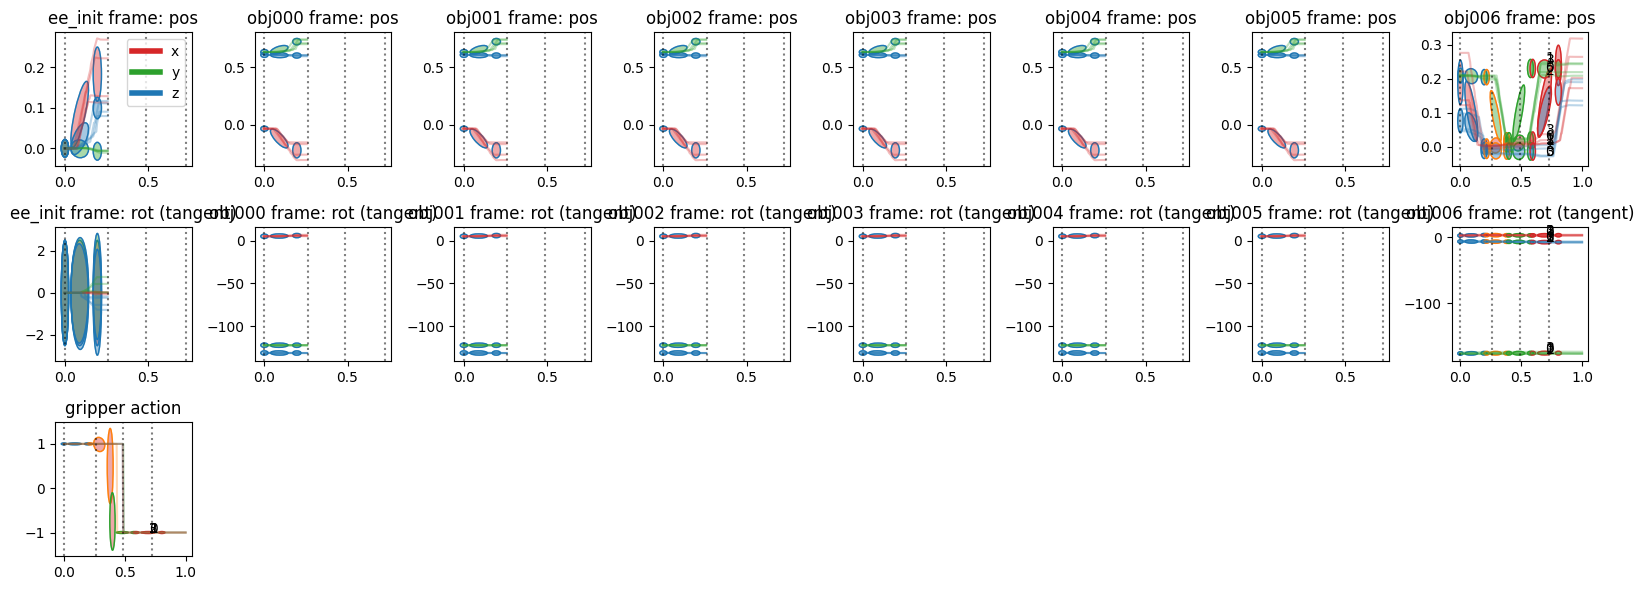

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 03:45:30.984 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:45:30.985 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:45:31.002 | INFO     |  HMM EM ...
2025-08-05 03:45:31.037 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-05 03:45:31.441 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-05 03:45:37.255 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[4.13e-011, 2.16e-011, 9.28e-012, 3.25e-012, 9.19e-013, 2.07e-013,
          3.71e-014, 5.25e-015, 5.83e-016, 5.06e-017, 3.43e-018, 1.80e-019,
          7.21e-021, 9.51e-023, 1.20e-025, 4.38e-030, 1.42e-036, 1.29e-045,
          1.05e-057, 2.55e-073, 6.19e-093, 5.11e-117, 5.03e-146, 2.16e-180,
          1.50e-220, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 4.52e-011, 2.34e-011,
          9.52e-012, 2.97e-012, 6.99e-013, 1.23e-013, 1.61e-014, 1.54e-015,
          1.09e-016, 5.58e-018, 2.08e-019, 5.62e-021, 1.09e-022, 1.53e-024,
          1.54e-026, 1.11e-028, 5.68e-031, 2.07e-033, 2.33e-036, 2.37e-040,
          6.

2025-08-05 03:45:44.776 | INFO     |  Did not specify time_based, deciding automatically.


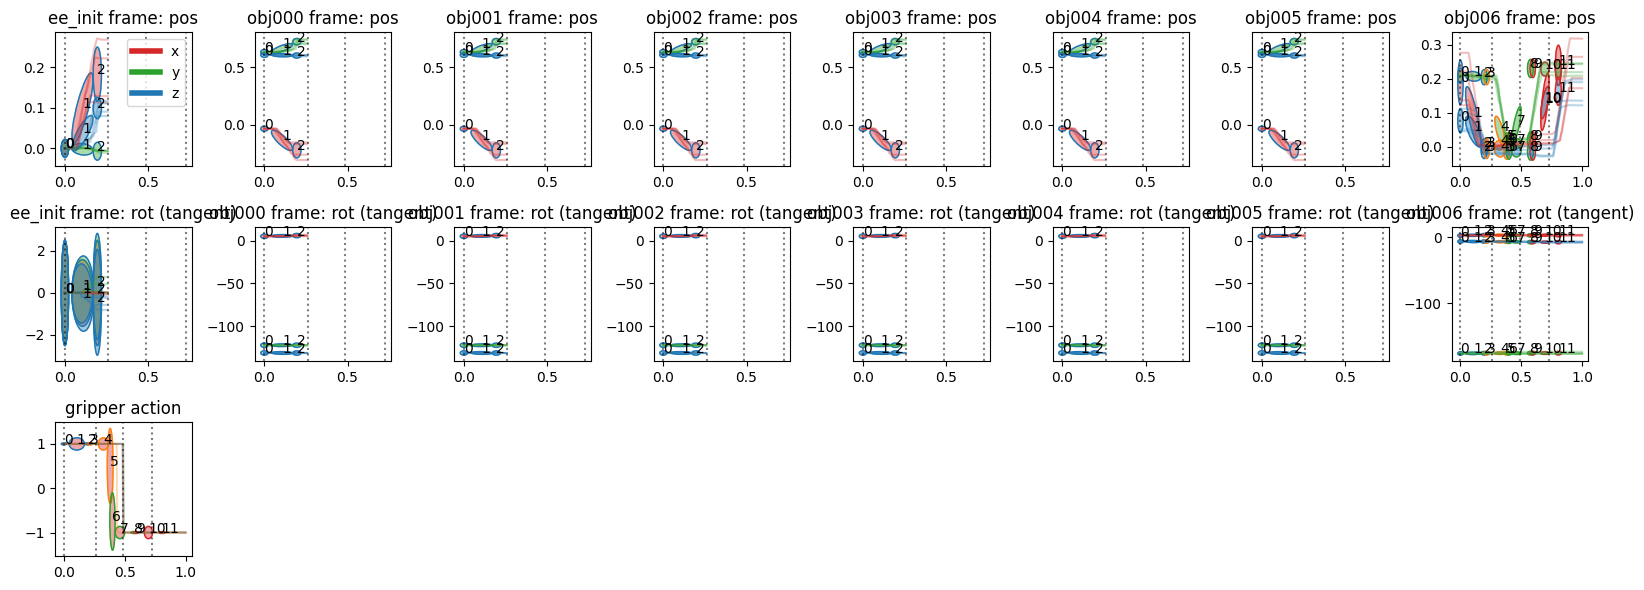

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

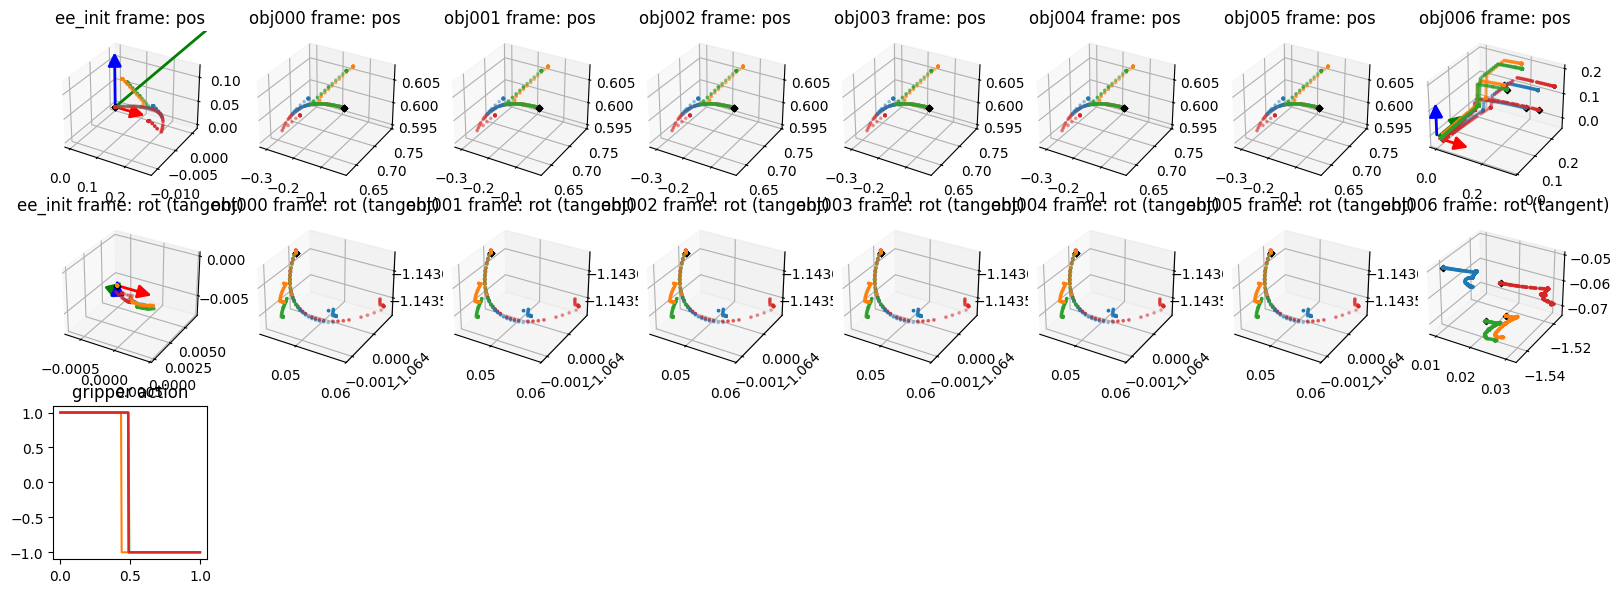

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

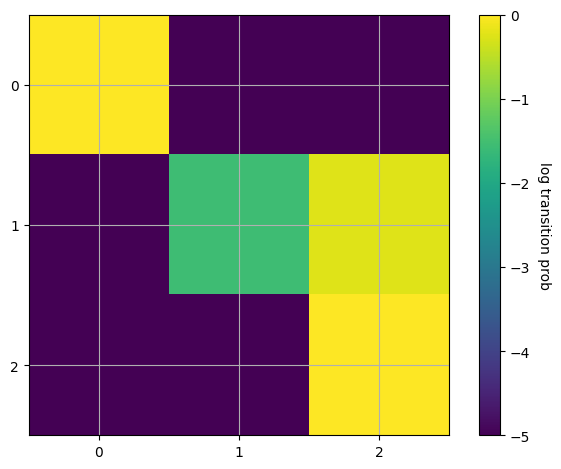

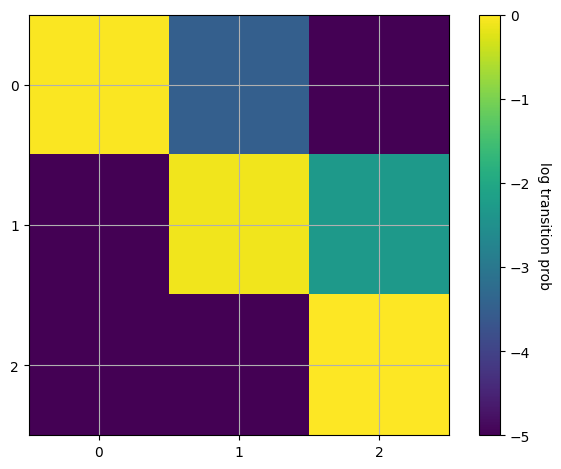

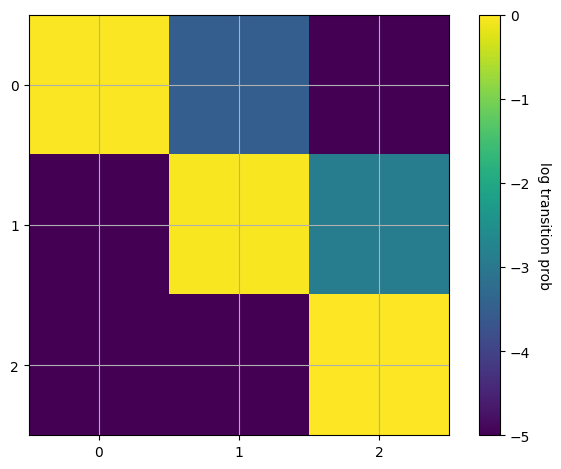

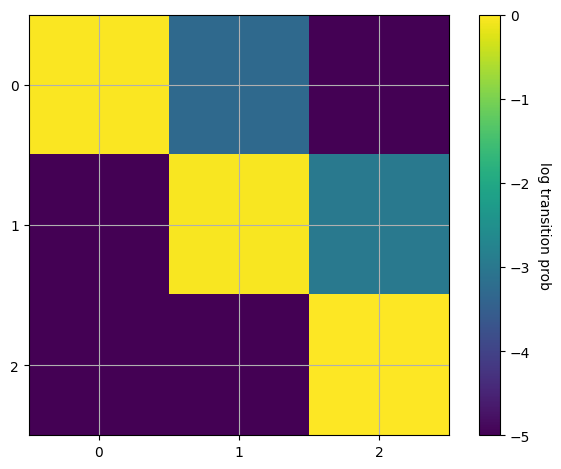

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-05 03:46:00.285 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-05 03:46:00.609 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-05 03:46:00.722 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]), array([[1.]]))
2025-08-05 03:46:00.722 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:46:00.802 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:46:01.658 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:46:01.788 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:46:01.874 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:46:01.967 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

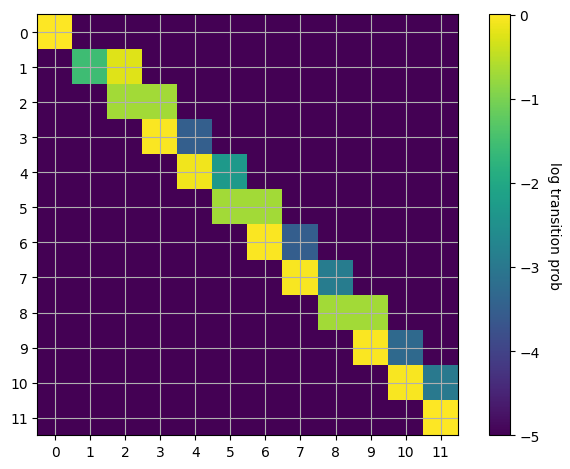

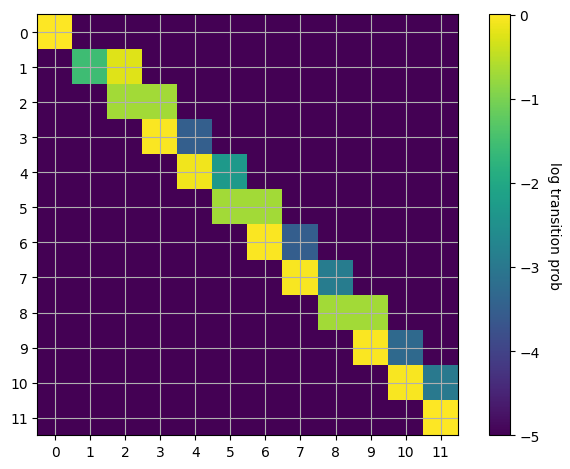

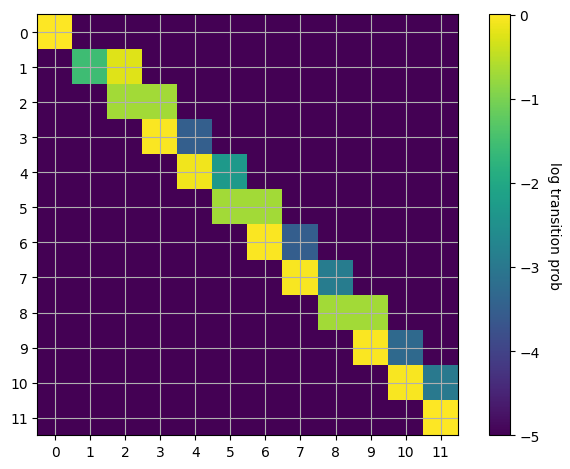

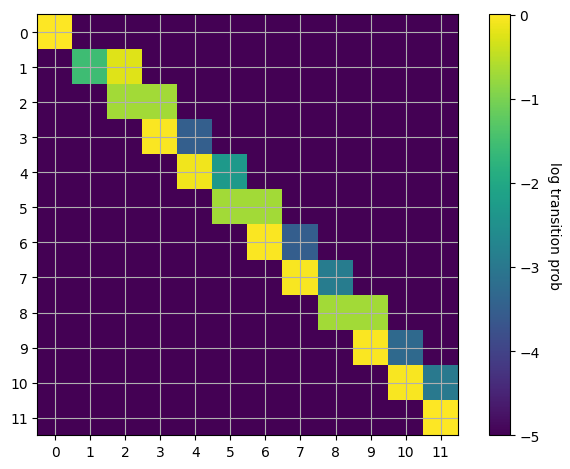

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-05 03:46:16.367 | INFO     |  Taking frame origins from demos.


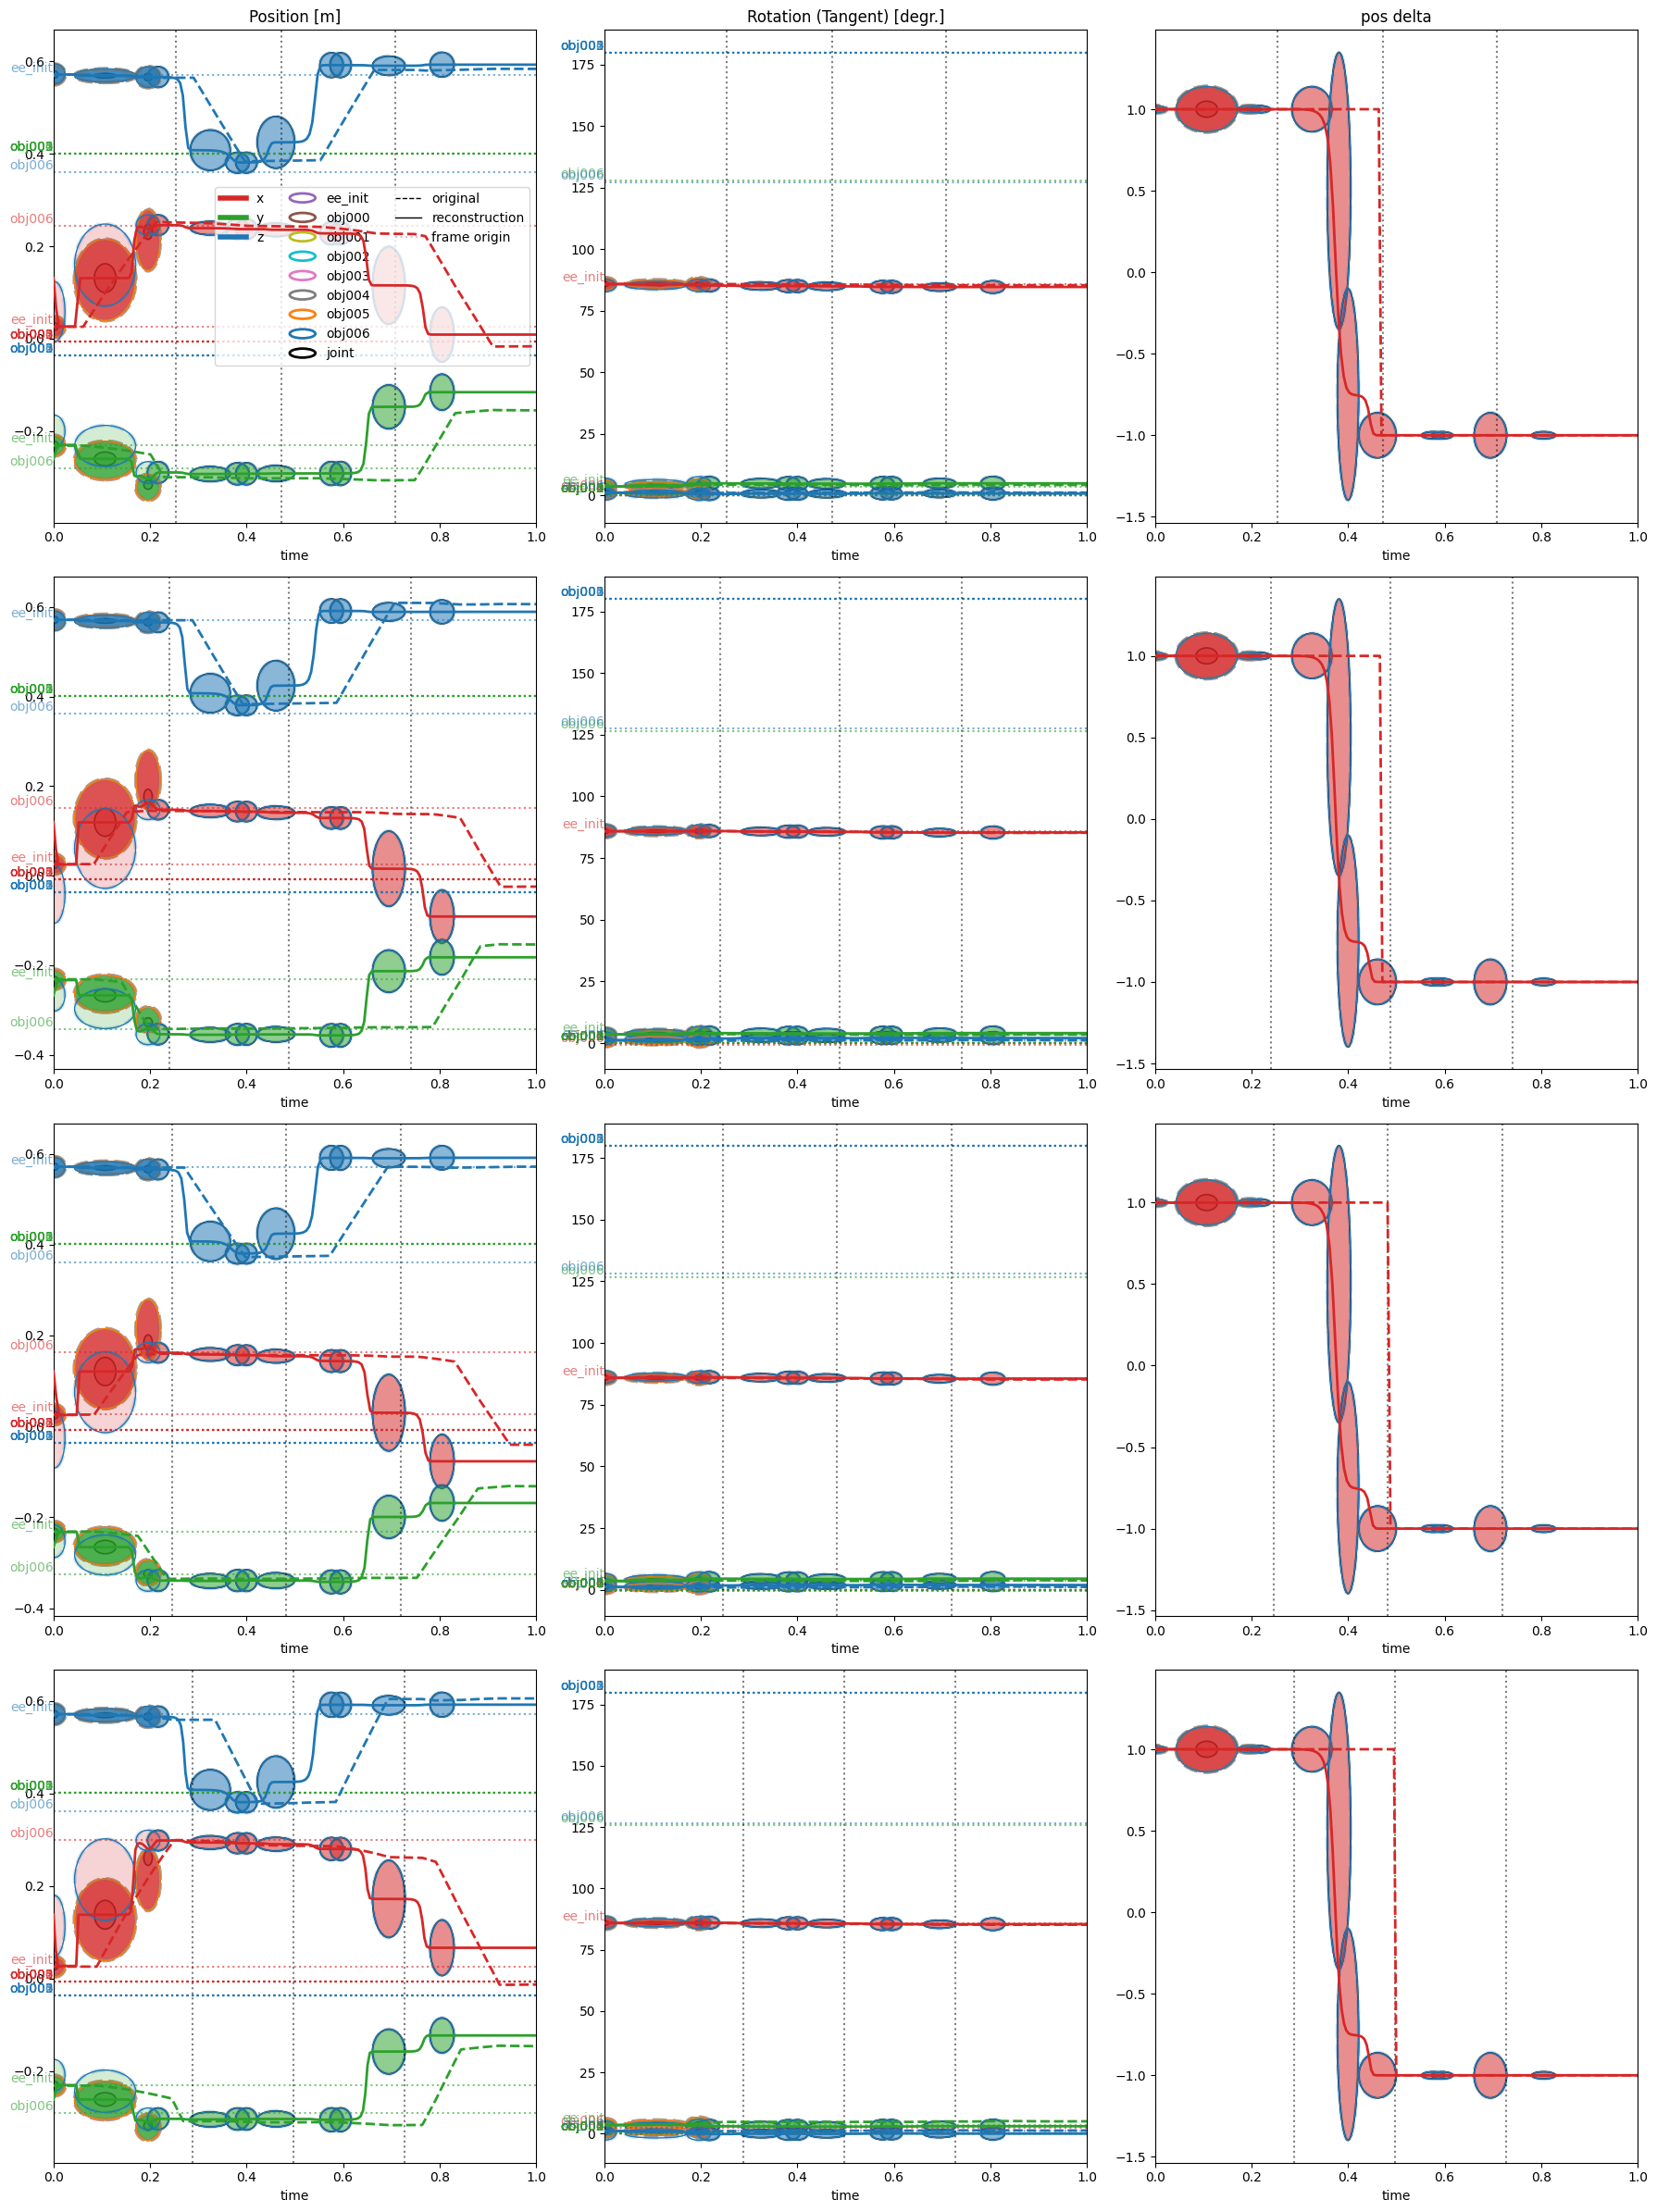

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range

: 